<a href="https://colab.research.google.com/github/alexisakov/RTPI/blob/master/Hard_numbers_Case_study_4_Price_projections_using_Facebook_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a toy example which shows how to:

* Retrieve price data on individual good/item.
* Prepare the data in a format that is suitable for feeding in Facebook Prophet. 
* Making projections and a bit of data analisys using Facebook Prophet.

# Preliminaries

First, lets install Facebook Prophet - you need to do this once. 

In [1]:
from IPython.display import clear_output
try:
  !pip install pystan
  !pip install --upgrade git+https://github.com/jroakes/google-analytics.git
  !pip install fbprophet
except:
  pass
finally:
  clear_output()

Import components...

In [50]:
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

...and a bit more components:

In [3]:
import requests
import numpy as np
import pandas as pd
import plotly

Set up connection to the Hard Numbers API - you will need your API Key - reach us to get one: https://t.me/xiskv.

In [61]:
base_url='http://rtpiapi.hrdn.io/'

token = 'YOUR API TOKEN'


request_headers = {'Authorization': f'Bearer {token}',
                    'Content-Type': 'application/json',
                    'Range-Unit': 'items'
                  }

Next let's get the data on what unique products are tracked in some particular category.

For this example I want to see all the fresh tomatoes which are tracked in the Rosstat's 'Fresh tomatoes' category.

To get the needed ID use the Rosstat's codebook: https://rosstat.gov.ru/storage/mediabank/bUwgHeap/nabor-2021-2018.XLSX

In this particular cases the needed code is 2623 - here we make the API URL request string to get all fresh tomatoes:

In [5]:
rosstat_id = 2623

request_url = base_url + f"rtpi_price_page?select=*&rosstat_id=eq.{rosstat_id}"

OK, now let's make the request to API:

In [6]:
response = requests.get(request_url, headers = request_headers).json()

Okay, there is a fair bit of tomatoes tracked - I select the first one by poping its web_price_id - its unique identifier within our Hard Numbers database:

In [8]:
webid = response.pop()['web_price_id']

Having some tomatoe ID we can construct a request to get all prices that have been historically observed for this particular tomatoe (sold by a particular retailer):

In [10]:
request_url =base_url + f"rtpi_price?select=*&web_price_id=eq.{webid}"
prices = requests.get(request_url, headers = request_headers).json()

Having the data we can put it into the DataFrame:

In [64]:
df = pd.DataFrame(prices)
df['date_observe'] = pd.to_datetime(df['date_observe'])
df.set_index('date_observe',inplace=True)
df

,web_price_id,stock_status,current_price,crossed_price,contributor_id
date_observe,,,,,
2020-06-22 16:03:06.880,154535,InStock,219.0,NaN,1
2020-06-25 15:34:33.010,154535,InStock,189.9,NaN,1
2020-07-01 23:49:31.027,154535,InStock,149.9,189.9,1
2020-07-02 22:50:14.387,154535,OutOfStock,NaN,NaN,1
2020-07-03 08:35:54.887,154535,InStock,149.9,189.9,1
...,...,...,...,...,...
2021-03-11 02:42:40.500,154535,InStock,239.9,NaN,1
2021-03-14 19:28:39.000,154535,OutOfStock,NaN,NaN,4
2021-03-16 11:33:03.000,154535,InStock,239.9,NaN,4


We then transform the data to daily frequency and forward fill the gaps in the data - this is a bit controversial (the N/A filling part), but this is a toy example:

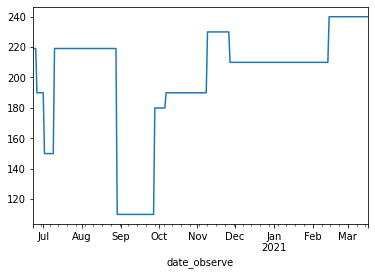

In [65]:
df_p = df[['current_price']]
df_p = df_p.resample('D').ffill()
df_p = df_p.fillna(method='ffill').dropna()
df_p['current_price'].plot()

Prophet wants a data frame with the 'y' data and 'ds' date columns - so here is a bit of renaming:

In [67]:
df_p.rename(columns={'current_price':'y'},inplace=True)
df_p.rename_axis("ds",inplace=True)
df_p = df_p.reset_index()

Initialize the Prophet and fit:

In [90]:
m = Prophet(changepoint_prior_scale=0.3)
m.fit(df_p)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Make 30 day forecast and plot:

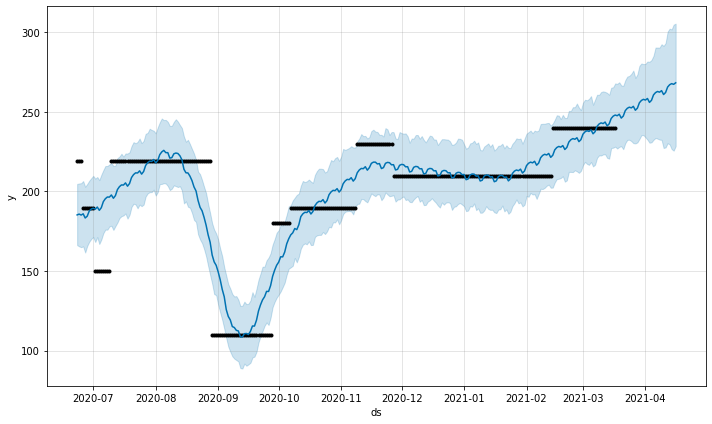

In [91]:
future = m.make_future_dataframe(freq='D', periods=30)
pj = m.predict(future)
m.plot(pj);

Plot the components: the trend and the seasonality:

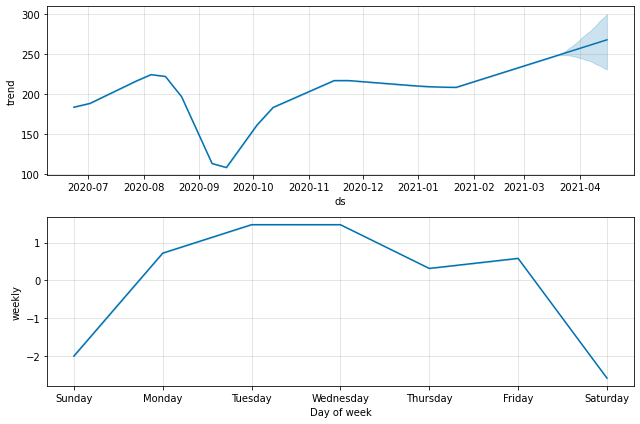

In [92]:
 m.plot_components(pj);

Here is a bit of a visual guide of trend shifts:

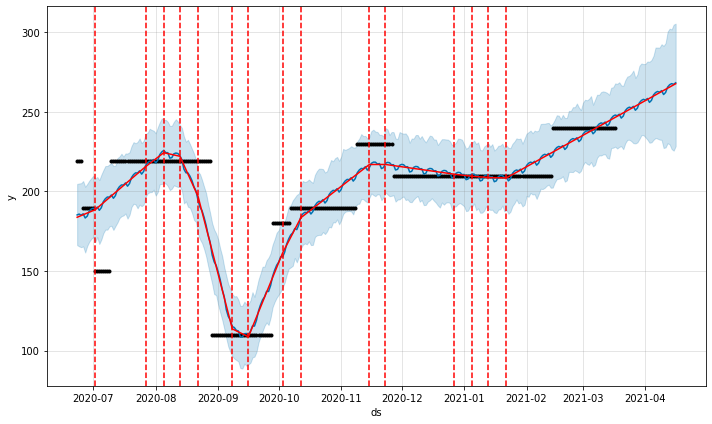

In [93]:
fig = m.plot(pj)
a = add_changepoints_to_plot(fig.gca(), m, pj )